## Fitting Induction data to the Transitional Matrix model using softmax rule

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tesser import cython_sr
from tesser import cython_fit
from tesser import util
import importlib

In [2]:
data_dir= "/mnt/c/Users/rodv2/Dropbox/tesser_successor/Data"
tdir = "/home/work-machine/Preston_Lab/tesser_successor/Data"
fitted_path= "/mnt/c/Users/rodv2/Dropbox/tesser_successor/Figures/fitted_models/"

In [3]:
induct_all = util.load_induct(data_dir)
struct_all = util.load_struct(data_dir)
n_states = 21
subj_list = util.subj_list()

In [4]:
transition_all = cython_sr.transition_multiple(subj_list, tdir+"/Transitional_Matrices")

In [5]:
transition_all.keys()

dict_keys([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138])

In [6]:
tranmodel = transition_all

In [7]:
# Using a hybrid model function when weight 'w' is set to 0 the model is fixed only to the community matrix.
fixed = {}
var_names = ['gamma', 'alpha', 'tau', 'w']
var_bounds = {'gamma': [0, 1], 'alpha': [0, 1], 'tau': [0, 10], 'w': [0, 1]}
results = cython_fit.fit_induct_indiv(struct_all, induct_all, fixed, var_names, var_bounds, split =False,
                               n_states=n_states, verbose=False, model_type='true transitional', model=tranmodel,split_list=[])

Estimating parameters for 100...
Estimating parameters for 101...
Estimating parameters for 102...
Estimating parameters for 103...
Estimating parameters for 104...
Estimating parameters for 105...
Estimating parameters for 106...
Estimating parameters for 107...
Estimating parameters for 108...
Estimating parameters for 109...
Estimating parameters for 110...
Estimating parameters for 111...
Estimating parameters for 112...
Estimating parameters for 113...
Estimating parameters for 114...
Estimating parameters for 115...
Estimating parameters for 116...
Estimating parameters for 117...
Estimating parameters for 119...
Estimating parameters for 120...
Estimating parameters for 121...
Estimating parameters for 122...
Estimating parameters for 123...
Estimating parameters for 124...
Estimating parameters for 125...
Estimating parameters for 126...
Estimating parameters for 127...
Estimating parameters for 128...
Estimating parameters for 129...
Estimating parameters for 130...
Estimating

In [8]:
results = results.set_index('subject')
results.head()

,gamma,alpha,tau,w,log_like,k,n
subject,,,,,,,
100,0.376479,0.407138,7.917369,0.000000,-29.112182,4,42
101,0.992612,0.726767,0.820783,0.733236,-25.324311,4,42
102,0.915994,0.013471,0.072642,0.705843,-21.002741,4,42
103,0.001196,0.951248,0.041024,0.920764,-24.458424,4,42
104,0.000000,1.000000,0.327508,0.586809,-27.130966,4,42


In [9]:
results.to_csv("./Data/hybrid_results/hybrid_transition.csv")

## Get response probabilities for the fitted models

In [10]:
importlib.reload(cython_fit)

<module 'tesser.cython_fit' from '/home/work-machine/Preston_Lab/tesser_successor/tesser/cython_fit.py'>

In [11]:
res_list = []
for subject in results.index.unique():
    subj_filter = f'SubjNum == {subject}'
    subj_struct = struct_all.query(subj_filter)
    subj_induct = induct_all.query(subj_filter)
    subj_param = results.loc[subject]
    param = {'alpha': subj_param['alpha'], 'gamma': subj_param['gamma'],
             'tau': subj_param['tau'], 'w' : subj_param['w']}
    res = cython_fit.assess_induct_fit_subject_hybrid(subj_struct, subj_induct, param, n_states, False, model_type='true transitional', model=tranmodel)
    res_list.append(res)
fitted = pd.concat(res_list, axis=0)

In [12]:
fitted

,SubjNum,TrialNum,QuestType,Environment,Source,Accuracy
0,100,1,Prim,ocean,Data,0.000000
1,100,2,Bound2,desert,Data,0.000000
2,100,3,Prim,desert,Data,1.000000
3,100,4,Prim,ocean,Data,1.000000
4,100,5,Prim,ocean,Data,0.000000
...,...,...,...,...,...,...
79,138,38,Prim,desert,Model,0.491349
80,138,39,Prim,forest,Model,0.699787
81,138,40,Prim,ocean,Model,0.459133
82,138,41,Bound1,forest,Model,0.423357


## Plot individual differences in induction

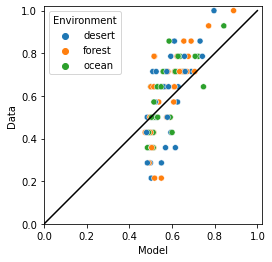

In [13]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='Environment', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

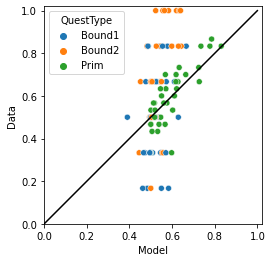

In [14]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='QuestType', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

## Plot group means

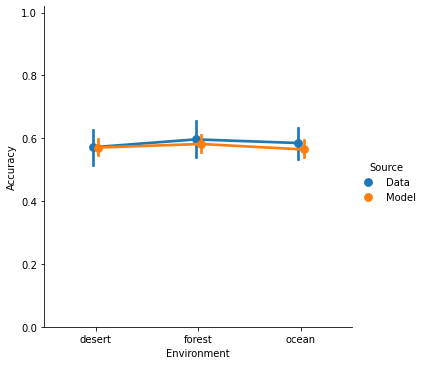

In [15]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='Environment', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

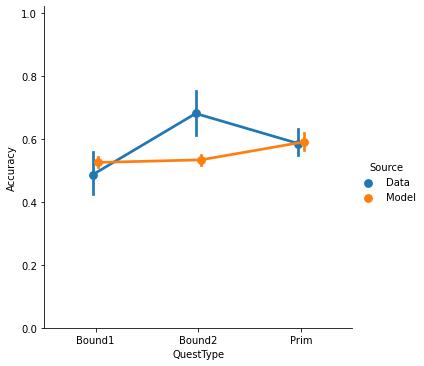

In [16]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='QuestType', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

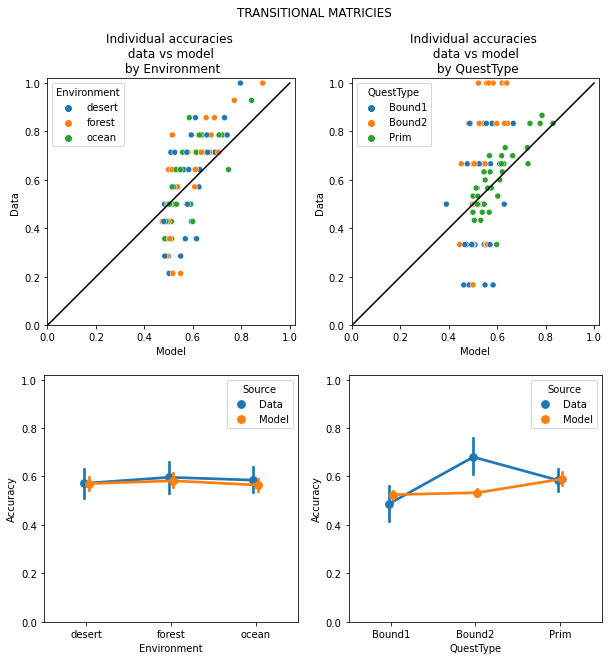

In [17]:
fitted = cython_fit.fitted_results(struct_all, induct_all, results, n_states, False, 'true transitional', tranmodel)
fig = cython_fit.plot_by_question(fitted, fig_name='Transitional matricies')

In [18]:
results.to_csv(fitted_path+"results/transition_only.csv")
fig.savefig(fitted_path+'accuracy_plots/transition_only.pdf')

## Add weights by question

In [7]:

fixed = {}
var_names = ['gamma',  'alpha', 'tau', 'w_prim' ,'w_bound1', 'w_bound2']
var_bounds = {'gamma': [0, 1], 'alpha': [0, 1], 'tau': [0, 10],
              'w_prim' : [0, 1], 'w_bound1' : [0, 1], 'w_bound2' : [0, 1]}
results_w= cython_fit.fit_induct_indiv(struct_all, induct_all, fixed, var_names, var_bounds, split =True,
                               n_states=n_states, verbose=False, model_type='true transitional', model=tranmodel, split_list =["w"])

Estimating parameters for 100...
Estimating parameters for 101...
Estimating parameters for 102...
Estimating parameters for 103...
Estimating parameters for 104...
Estimating parameters for 105...
Estimating parameters for 106...
Estimating parameters for 107...
Estimating parameters for 108...
Estimating parameters for 109...
Estimating parameters for 110...
Estimating parameters for 111...
Estimating parameters for 112...
Estimating parameters for 113...
Estimating parameters for 114...
Estimating parameters for 115...
Estimating parameters for 116...
Estimating parameters for 117...
Estimating parameters for 119...
Estimating parameters for 120...
Estimating parameters for 121...
Estimating parameters for 122...
Estimating parameters for 123...
Estimating parameters for 124...
Estimating parameters for 125...
Estimating parameters for 126...
Estimating parameters for 127...
Estimating parameters for 128...
Estimating parameters for 129...
Estimating parameters for 130...
Estimating

In [8]:
results_w = results_w.set_index('subject')
results_w.head()

,gamma,alpha,tau,w_prim,w_bound1,w_bound2,log_like,k,n
subject,,,,,,,,,
100,1.000000,0.993740,0.017177,0.000461,0.003474,1.000000,-23.860782,6,42
101,0.991521,0.676613,0.708488,0.814039,0.617141,0.000000,-24.935172,6,42
102,0.000000,0.017044,0.063324,1.000000,0.000000,0.000000,-20.452549,6,42
103,0.012674,0.990081,0.002125,0.928103,0.008016,0.612502,-22.394058,6,42
104,0.000000,0.996088,0.092361,1.000000,0.064367,0.000000,-26.169324,6,42


In [9]:
results_w.to_csv(f"./Data/hybrid_results/hybrid_transition_weighted.csv")

## Get response probabilities for the fitted models

In [17]:
importlib.reload(cython_fit)

<module 'tesser.cython_fit' from '/home/work-machine/Preston_Lab/tesser_successor/tesser/cython_fit.py'>

In [23]:
res_list = []
for subject in results_w.index.unique():
    subj_filter = f'SubjNum == {subject}'
    subj_struct = struct_all.query(subj_filter)
    subj_induct = induct_all.query(subj_filter)
    subj_param = results_w.loc[subject]
    param = {'alpha': subj_param['alpha'], 'gamma': subj_param['gamma'], 'tau': subj_param['tau'],
             'w_prim' : subj_param['w_prim'], 'w_bound1' : subj_param['w_bound1'], 'w' : subj_param['w_bound2']
            }
    res = cython_fit.assess_induct_fit_subject_hybrid(subj_struct, subj_induct, param, n_states, False, 'true transitional',tranmodel)
    res_list.append(res)
fitted = pd.concat(res_list, axis=0)

In [24]:
fitted

,SubjNum,TrialNum,QuestType,Environment,Source,Accuracy
0,100,1,Prim,ocean,Data,0.000000
1,100,2,Bound2,desert,Data,0.000000
2,100,3,Prim,desert,Data,1.000000
3,100,4,Prim,ocean,Data,1.000000
4,100,5,Prim,ocean,Data,0.000000
...,...,...,...,...,...,...
79,138,38,Prim,desert,Model,0.490919
80,138,39,Prim,forest,Model,0.516926
81,138,40,Prim,ocean,Model,0.510626
82,138,41,Bound1,forest,Model,0.500000


## Plot individual differences in induction

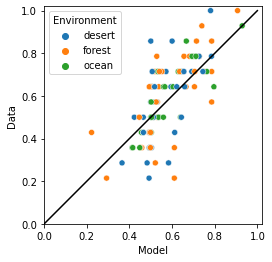

In [25]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='Environment', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

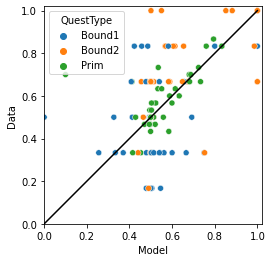

In [26]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='QuestType', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

## Plot group means

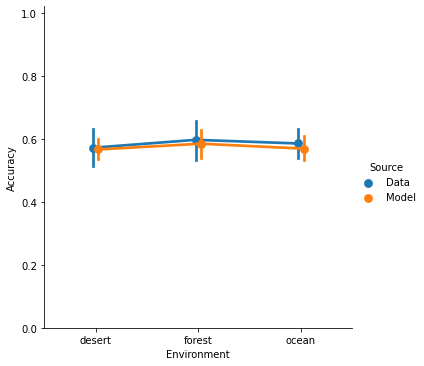

In [27]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='Environment', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

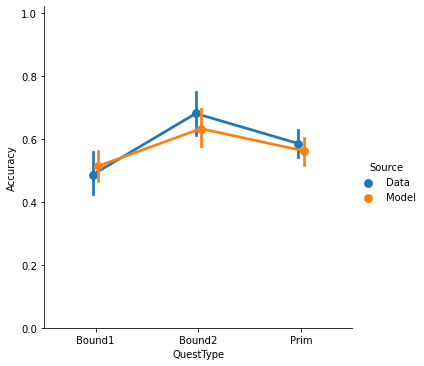

In [28]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='QuestType', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

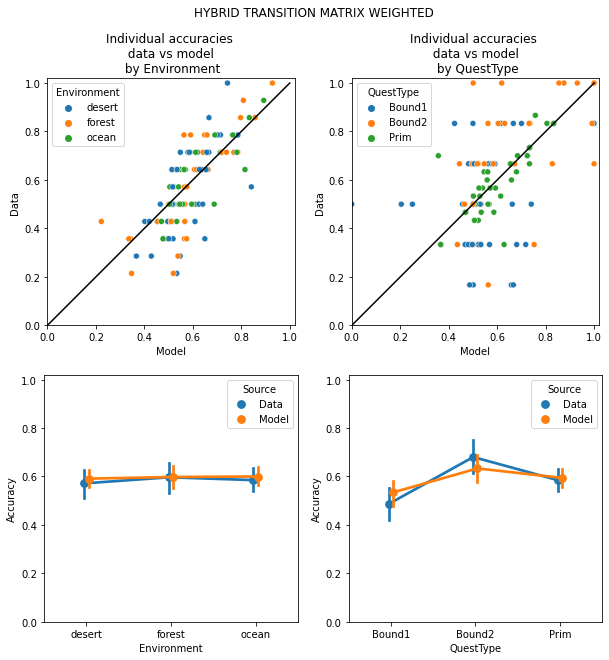

In [18]:
fitted2 = cython_fit.fitted_results(struct_all, induct_all, results_w, n_states, True, 'true transitional', tranmodel)
fig2 = cython_fit.plot_by_question(fitted2,  fig_name='Hybrid Transition Matrix weighted')

In [11]:
results_w.to_csv(fitted_path+"results/hybrid_transition_weighted.csv")
fig2.savefig(fitted_path+'accuracy_plots/hybrid_transition_weighted.pdf')

In [15]:
fitted2.Accuracy.max()

2.0